In [5]:
## 1. 環境與套件匯入
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import MCXGate, CRYGate
from qiskit.visualization import plot_histogram
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
import numpy as np, random, math
import pkg_resources
print(f"Qiskit: {pkg_resources.get_distribution('qiskit').version}, qiskit-aer: {pkg_resources.get_distribution('qiskit-aer').version}")

Qiskit: 2.0.1, qiskit-aer: 0.17.0


In [16]:
## 2. 參數與隨機目標
n = 3 
N = 2**n
shots = 1024
target_index = random.randrange(N)
memory = [0]*N
memory[target_index] = 1
target_str = format(target_index, f'0{n}b')
print(f"Selected target: {target_index} -> |{target_str}>\n")

Selected target: 1 -> |001>



In [17]:
# 3. 宣告量子暫存器
addr = QuantumRegister(n, 'addr')              # 位址寄存器
router = QuantumRegister(N, 'router')          # router 作為decoder
anc  = QuantumRegister(1, 'anc') 
data = QuantumRegister(1, 'data')              # 資料位元
cl = ClassicalRegister(n, 'cl')                # classical register
qc = QuantumCircuit(addr, router, anc , data, cl)

# Step 1: 地址寄存器進行 Hadamard gate (超疊加)
qc.h(addr)




In [18]:
import math
iterations = int((math.pi / 4) * math.sqrt(2**n))  # Optimal number of iterations
for _ in range(iterations):
    for i in range(N):
        bin_address = format(i, f'0{n}b')

        # 將位址轉成 decoder 訊號
        for bit_idx, bit_val in enumerate(bin_address):
            if bit_val == '0':
                qc.x(addr[bit_idx])

        # 建立Toffoli (multi-controlled X)，設定router[i] = decoder的結果
        qc.mcx(addr, router[i])

        # 還原位址狀態
        for bit_idx, bit_val in enumerate(bin_address):
            if bit_val == '0':
                qc.x(addr[bit_idx])

    # Step 3: 使用 router 加載資料至 data qubit
    for i in range(N):
        if memory[i] == 1:
            qc.cx(router[i], data[0])
    
    qc.z(data[0])
    # Step 5: QRAM 資料卸載 (reverse operation)
    for i in reversed(range(N)):
        if memory[i] == 1:
            qc.cx(router[i], data[0])

    # Step 6: 清除 router
    for i in reversed(range(N)):
        bin_address = format(i, f'0{n}b')

        for bit_idx, bit_val in enumerate(bin_address):
            if bit_val == '0':
                qc.x(addr[bit_idx])

        qc.mcx(addr, router[i])

        for bit_idx, bit_val in enumerate(bin_address):
            if bit_val == '0':
                qc.x(addr[bit_idx])
    
    ## 5. 擴散算子 (Diffuser)
    qc.h(addr)
    qc.x(addr)
    qc.h(addr[-1])
    qc.mcx(addr[:-1], addr[-1], ancilla_qubits=[anc[0]])
    qc.h(addr[-1])
    qc.x(addr)
    qc.h(addr)

Analytic success probability: 0.9453, k_opt = 2

Total qubits: 13
Gate counts: OrderedDict({'x': 108, 'mcx': 32, 'h': 19, 'measure': 12, 'cx': 4, 'z': 2, 'ccx': 2})
Circuit depth: 99


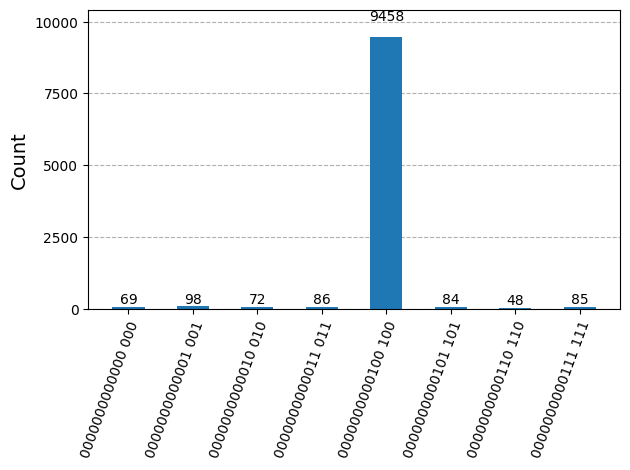

In [22]:
## 6. 測量與解析性評估
qc.measure(addr, cl)
theta0 = math.asin(1/math.sqrt(N))
k_opt = math.floor(math.pi/(4*theta0))
P_theory = math.sin((2*k_opt+1)*theta0)**2
print(f"Analytic success probability: {P_theory:.4f}, k_opt = {k_opt}\n")
print(f"Total qubits: {qc.num_qubits}")
print(f"Gate counts: {qc.count_ops()}")
print(f"Circuit depth: {qc.depth()}")

# 6.3 縮小規模模擬示意
small_shots = 10000
sim_small = AerSimulator()
qc_small = qc.copy()  # 你需要先重建一个 n=3、memory 大小 8 的电路
qc_small.measure_all()
result = sim_small.run(qc_small, shots=small_shots).result()
counts = result.get_counts()
plot_histogram(counts)

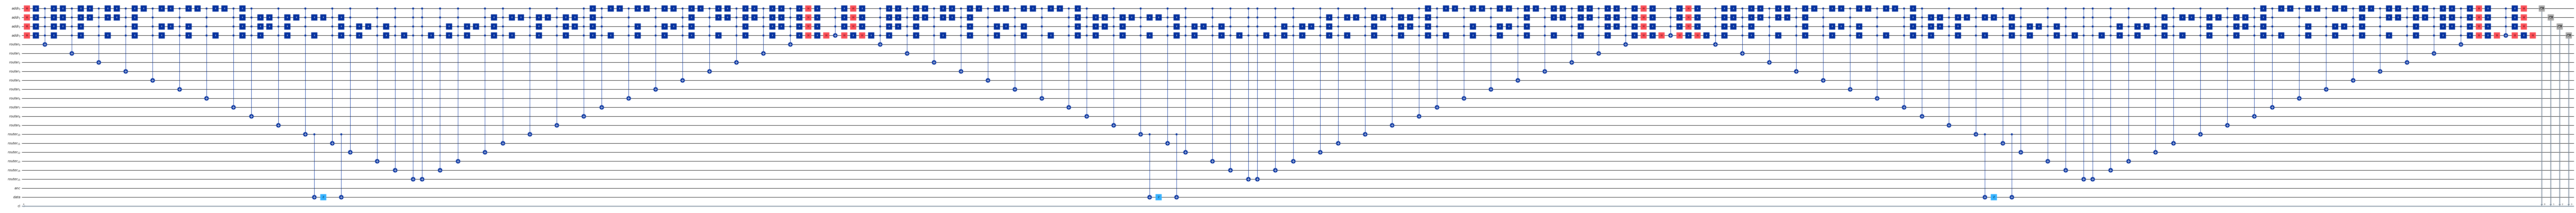

In [6]:
from qiskit.visualization import circuit_drawer

# 使用 Matplotlib 绘制
circuit_drawer(qc, output='mpl', fold=-1)
# 直接在 notebook 里输出 ASCII/Unicode 图
#print(qc.draw('text'))